In [ ]:
from nsepy import get_history as gh
import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

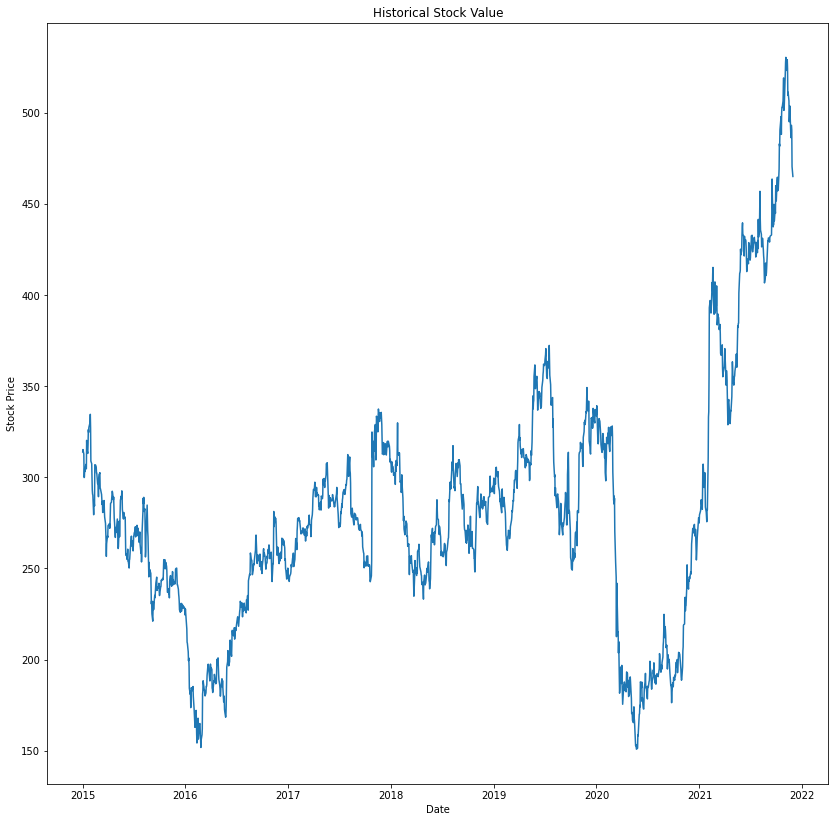

Epoch 1/15
45/45 [==============================] - 18s 156ms/step - loss: 0.0110
Epoch 2/15
45/45 [==============================] - 5s 115ms/step - loss: 0.0042
Epoch 3/15
45/45 [==============================] - 4s 84ms/step - loss: 0.0035
Epoch 4/15
45/45 [==============================] - 4s 82ms/step - loss: 0.0030
Epoch 5/15
45/45 [==============================] - 4s 86ms/step - loss: 0.0030
Epoch 6/15
45/45 [==============================] - 4s 95ms/step - loss: 0.0024
Epoch 7/15
45/45 [==============================] - 4s 90ms/step - loss: 0.0026
Epoch 8/15
45/45 [==============================] - 4s 95ms/step - loss: 0.0024
Epoch 9/15
45/45 [==============================] - 4s 88ms/step - loss: 0.0021
Epoch 10/15
45/45 [==============================] - 4s 91ms/step - loss: 0.0020
Epoch 11/15
45/45 [==============================] - 4s 91ms/step - loss: 0.0022
Epoch 12/15
45/45 [==============================] - 4s 97ms/step - loss: 0.0019
Epoch 13/15
45/45 [===============

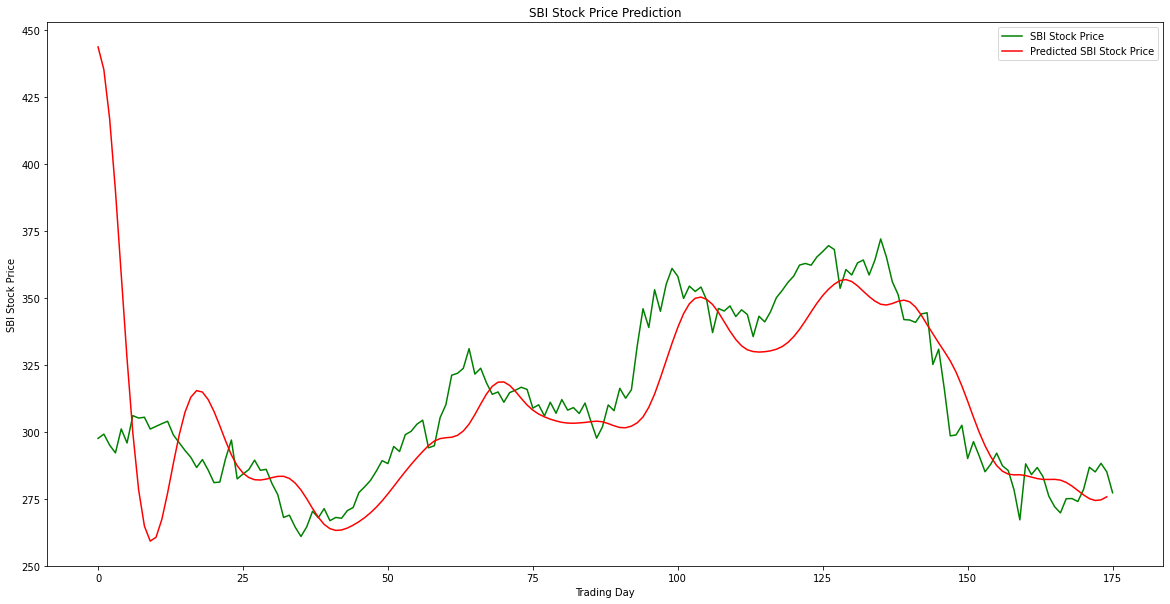

In [ ]:
#Setting start and end dates and fetching the historical data
start = dt.datetime(2015,1,1)
end = dt.datetime(2021,11,29)
stk_data = gh(symbol='SBI',start=start,end=end)
stk_data

#Visualizing the fetched data
plt.figure(figsize=(14,14))
plt.plot(stk_data['Close'])
plt.title('Historical Stock Value')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

#Data Preprocessing
stk_data['Date'] = stk_data.index
data2 = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
data2['Date'] = stk_data['Date']
data2['Open'] = stk_data['Open']
data2['High'] = stk_data['High']
data2['Low'] = stk_data['Low']
data2['Close'] = stk_data['Close']
train_set = data2.iloc[:, 1:2].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)
X_train = []
y_train = []
for i in range(60, 1482):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


#Defining the LSTM Recurrent Model
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

#Compiling and fitting the model
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 15, batch_size = 32)


#Fetching the test data and preprocessing
testdataframe = gh(symbol='SBI',start=dt.datetime(2019,1,1),end=dt.datetime(2019,9,18))
testdataframe['Date'] = testdataframe.index
testdata = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
testdata['Date'] = testdataframe['Date']
testdata['Open'] = testdataframe['Open']
testdata['High'] = testdataframe['High']
testdata['Low'] = testdataframe['Low']
testdata['Close'] = testdataframe['Close']
real_stock_price = testdata.iloc[:, 1:2].values
dataset_total = pd.concat((data2['Open'], testdata['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(testdata) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 235):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#Making predictions on the test data
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

#Visualizing the prediction
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'green', label = 'SBI Stock Price')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted SBI Stock Price')
plt.title('SBI Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('SBI Stock Price')
plt.legend()
plt.show()